## Downloading images

In [4]:
!df

Filesystem     1K-blocks      Used Available Use% Mounted on
udev            31356220         0  31356220   0% /dev
tmpfs            6277116       860   6276256   1% /run
/dev/xvda1     508184812 391735064 116433364  78% /
tmpfs           31385576         0  31385576   0% /dev/shm
tmpfs               5120         0      5120   0% /run/lock
tmpfs           31385576         0  31385576   0% /sys/fs/cgroup
/dev/loop1         96256     96256         0 100% /snap/core/9066
/dev/loop2         18432     18432         0 100% /snap/amazon-ssm-agent/1480
/dev/loop3         18432     18432         0 100% /snap/amazon-ssm-agent/1566
tmpfs            6277112        20   6277092   1% /run/user/1000
/dev/loop4         99456     99456         0 100% /snap/core/9289


In [1]:
import pandas as pd

df = pd.read_csv('er_rel.csv')

In [2]:
df.creative_url.values[0]

'https://s3.eu-central-1.amazonaws.com/mnfst-video-creatives/creatives/a1b3ce0a195f3415ff36f363f2dedbbec77f9eb4/creative.jpg'

In [3]:
url = df.creative_url.values[0]

In [4]:
number = 100

In [2]:
!nvidia-smi

Thu May 28 08:13:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P0    38W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
import os
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm
from PIL import Image
import requests
import argparse

def get_results(value):
    try:
        index, row = value
        url = row["creative_url"]
        name = str(row['participation_id']) + '.jpg'
        picture_bytearray = requests.get(url, stream=True).raw
        image = Image.open(picture_bytearray)
        size = image.size
        path = "images_folder/" + name
        image.save(path)
    except:
        return {"image_name" : None, "size" : None}
    return {"image_name" : name, "size" : size}

with Pool(number) as p:
    r = list(tqdm(p.imap(get_results, df.iterrows()), total=len(df)))
    df["image_name"] = [x['image_name'] for x in r]
    df["size"] = [x['size'] for x in r]
    df.to_csv("er.csv")
    df.to_pickle("er.pk")


100%|██████████| 34089/34089 [02:46<00:00, 204.63it/s]


In [9]:
df['size'].value_counts()

(256, 256)      30909
(1080, 1080)     1994
(600, 600)       1070
(256, 257)         53
(257, 256)         46
(601, 600)          6
(601, 601)          4
(600, 601)          4
(602, 600)          1
Name: size, dtype: int64

In [13]:
df['er_rel_norm'] = (df.er_rel - df.er_rel.mean()) / df.er_rel.std()

In [26]:
df['image_name'] = df['image_name'].astype('str')

In [36]:
df = df[df['image_name'].str.contains('jpg')]

In [38]:
from sklearn.model_selection import train_test_split

In [91]:
df_norm = df[df['size'] != (256,256)]

In [92]:
df_norm_ = df_norm[df_norm['creative_id'] != 1079]

In [93]:
train, test  = train_test_split(df_norm_, test_size=0.3)

In [94]:
test = test.append( df_norm[df_norm['creative_id'] == 1079], sort=False)

In [95]:
train.to_csv("train_norm.csv")

In [96]:
test.to_csv("test_norm.csv")

In [99]:
df['er_rel_norm'].min()

-1.1894887685053621

In [97]:
df_train = df[df['size'] == (256,256)]

In [98]:
df_train.to_csv('train_low.csv')

In [10]:
import pandas as pd

In [27]:
df = pd.read_pickle('er.pk')

In [28]:
df['image_name'] = df['paths'].apply(lambda x : x.split('/')[-1])

In [33]:
import seaborn as sns
import numpy as np
import json

In [30]:
df = df[(df.er_rel < 2)]

In [31]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'participation_id',
       'original', 'creative', 'likes', 'shares', 'views', 'created_at',
       'link', 'followers', 'er_abs', 'provider_id', 'list_likes',
       'mean_likes', 'med_likes', 'er_med', 'er', 'er_rel', 'paths',
       'image_name'],
      dtype='object')

In [34]:
df['list_likes'] =df['list_likes'].apply(json.loads)

In [35]:
df['std_likes'] = df['list_likes'].apply(np.std)

In [40]:
df = df[df['std_likes'] / (df['med_likes'] + 1) < 1.5]

In [44]:
df = df[df.med_likes > 20]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


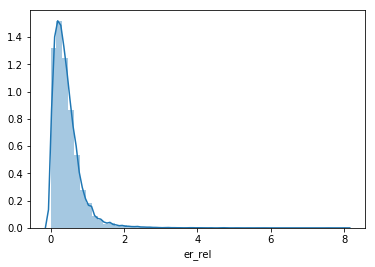

In [20]:
sns.distplot(np.log1p(df.er_rel))

In [46]:
df.to_csv("er_reduced.csv")
df.to_pickle("er_reduced.pk")

In [6]:
import torch

In [7]:
torch.__version__

'1.4.0'

In [50]:
np.std(df.er_rel - df.er_rel.mean())

0.3208874646526299

In [54]:
df.er_rel.mean()

0.3181818181818182